# Классификация заголовоков новостей на фейковые и настоящие 

## 0. Установка и подгрузука библиотек
Установка библиотек, под которым запускается данный бейзлайн.

In [32]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install tensorflow
!pip install pymorphy2
!pip install stop-words
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Using cached huggingface_hub-0.5.1-py3-none-any.whl (77 kB)
  Using cached sacremoses-0.0.49-py3-none-any.whl (895 kB)


In [34]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 100)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix
from random import sample
import random

import tqdm
from copy import deepcopy
import re

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logger = logging.getLogger()
logging.disable(logging.ERROR)

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import pickle

import pymorphy2
import stop_words

from transformers import AutoTokenizer, AutoModel

* зафиксируем все сиды для воспроизводимости результатов

In [8]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)     
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [47]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Загрузим датасет

In [9]:
data = pd.read_csv("dataset/train.tsv", sep="\t")
data.head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
1,Агент Кокорина назвал езду по встречке житейской историей,0
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
4,Против Навального завели дело о недоносительстве на Волкова,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем состоянии,0
9,Microsoft объявила дату выхода очков дополненной реальности Hololens,0


* Датасет загружен, проанализируем его содержимое

## 2. Препроцессинг заголовков новостей
1. Токенизация — разобьём каждый заголовок статьи на слова.
2. Нормализация — приведём слова к «рафинированному» виду (единый регистр слов, отсутствие знаков пунктуации, расшифрованные сокращения, словесное написание чисел и т.д.).
3. Стеммизация — приведём слова к его корню путем устранения придатков (суффикса, приставки, окончания).
4. Лемматизация — приведём слова к начальной форме.
5. Чистка — удаленим стоп-слова, которые не несут смысловой нагрузки (артикли, междометья).

* Для этого будем использовать библиотеку pymorphy2

In [10]:
russian_stopwords = stop_words.get_stop_words('ru')
count = 0
all_words = []
all_pre_words = []


def sentence_editor(title):
    global count
    txt = re.sub(pattern, "", title)  # удалим все посторонние знаки кроме букв
    txt = txt.strip(" ").lower()  # приведём все буквы к одному регистру
    txt = txt.split()  # разделим заголовок на список слов
    all_pre_words.extend(txt)
    new_txt = []
    for word in txt:
        word = morph.parse(word)[0].normal_form
        if word not in russian_stopwords:  # удалим не несущие смысла слова
            new_txt.append(word)
        else:
            count += 1
    all_words.extend(new_txt)
    txt = " ".join(new_txt)
    return txt


morph = pymorphy2.MorphAnalyzer()
new_title = []
pattern = "[^а-яА-Яa-zA-Z ё]"

for txt in tqdm.notebook.tqdm(data.title):
    new_title.append(sentence_editor(txt))

start = random.randint(0, len(new_title))
print(*new_title[start:start + 10], sep="\n")
print("УДАЛЕНО", count, "слов")

  0%|          | 0/5758 [00:00<?, ?it/s]

власть северный корея требовать немедленный возврат дрезина угнать российский дипломат
священник рассказать молитва российский олимпиец
госдума создать комиссия инспекция зарубежный курорт
успешный борьба женщина свой право новый костюм ильич возвращение навальный репрессия трамп еженедельный рубрика панорама неделя
новогодний ночь дмитрий песков похитить ус
французский табачник забастовать возмущение
путин разрешить наказывать просрочка отмена мобильный рабство
мосводоканал утвердить график плановый прорыв труба зимний период
итальянский футболист повторно уличный употребление кокаин
курс доллар приблизиться рубль
УДАЛЕНО 10000 слов


## 3. Визуализация данных


### Есть ли дисбаланс классов?

<AxesSubplot:xlabel='is_fake', ylabel='count'>

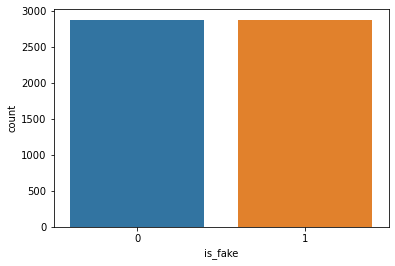

In [11]:
sns.countplot(x=data["is_fake"])

* Колличество фейковых и реальных новостей полностью совпадает, что не может не радовать

### Топ самых частых слов до удаления стоп-слов

In [12]:
NUMBER = 30
count_words = {}
for word in all_pre_words:
    if word in count_words:
        count_words[word] += 1
    else:
        count_words[word] = 1

most_frequency_words = {"word": sorted(count_words, key=lambda x: -count_words[x])[:NUMBER], 
                        "number": []}
for word in most_frequency_words["word"]:
    most_frequency_words["number"].append(count_words[word])


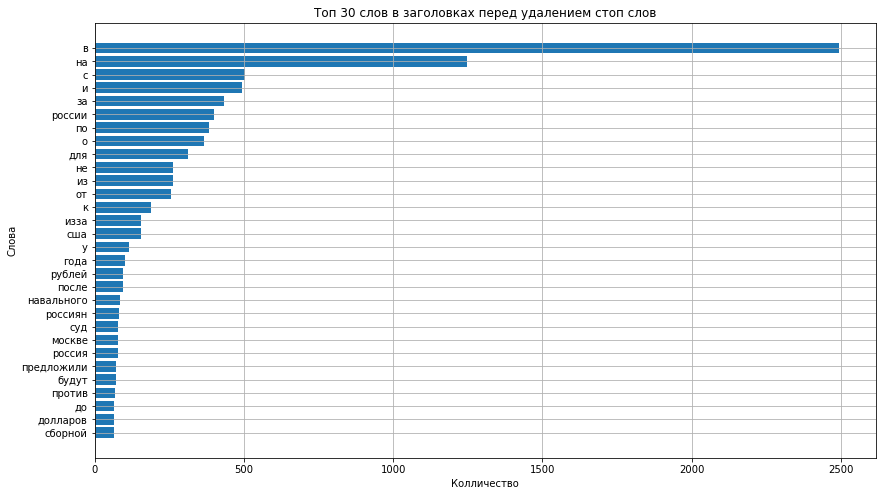

In [13]:
plt.figure(figsize=(14,8))
plt.barh(most_frequency_words["word"][::-1], most_frequency_words["number"][::-1])
plt.ylabel("Слова")
plt.xlabel("Колличество")
plt.title("Топ %d слов в заголовках перед удалением стоп слов" % (NUMBER))
plt.grid(True)

In [14]:
NUMBER = 30
count_words = {}
for word in all_words:
    if word in count_words:
        count_words[word] += 1
    else:
        count_words[word] = 1

most_frequency_words = {"word": sorted(count_words, key=lambda x: -count_words[x])[:NUMBER], 
                        "number": []}
for word in most_frequency_words["word"]:
    most_frequency_words["number"].append(count_words[word])


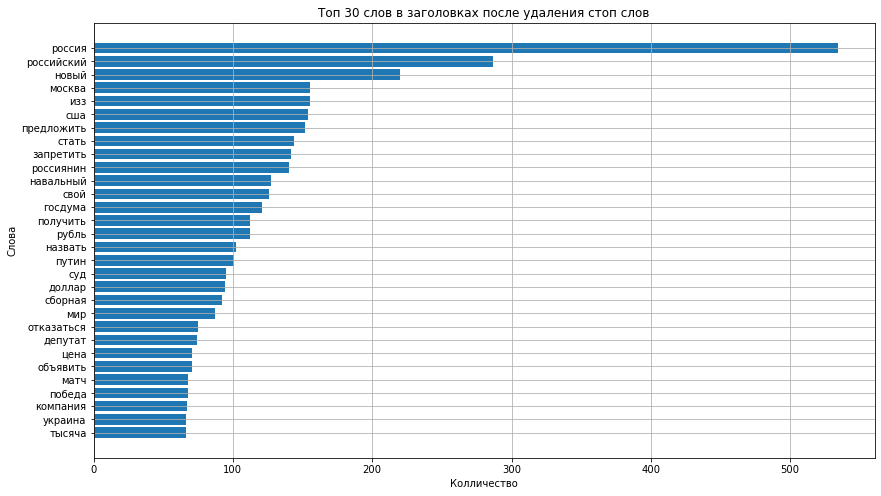

In [15]:
plt.figure(figsize=(14,8))
plt.barh(most_frequency_words["word"][::-1], most_frequency_words["number"][::-1])
plt.ylabel("Слова")
plt.xlabel("Колличество")
plt.title("Топ %d слов в заголовках после удаления стоп слов" % (NUMBER))
plt.grid(True)

## 4. Переведём каждый обработанный заголовок в векторное представление
* с помощью контекстуализированной модели от RusVectōrēs натренерованной на около 10 миллиардов слов
* будем создавать вектор для каждого слова, а в качестве вектора предложения будем брать среднее значение между всеми словами в нём

In [16]:
NEED_NEW_EMBENDINGS = False  # чтобы при каждом запуске кода не ждать пока фичи посчитаются

In [17]:
new_title[0]

'москвич владимир клутина прийти счёт вмешательство американский выборы'

* создадим массив векторного представления заголовков

In [18]:
if NEED_NEW_EMBENDINGS:
    elmo_model = ElmoModel()
    elmo_model.load("sentence_embender")

    title_matrix = np.array([[0] * 1024], dtype=float)
    batch_size = 32
    for i in tqdm.notebook.tqdm(range(0, len(new_title), batch_size)):
        title_matrix = np.append(title_matrix, 
                                 elmo_model.get_elmo_vector_average([x.split() for x in new_title[i:i + batch_size]]),
                                 axis=0)

    title_matrix = np.delete(title_matrix, 0, axis=0)
    title_matrix = np.concatenate((title_matrix, [[x] for x in new_title]), axis=1)
    title_matrix = np.concatenate((title_matrix, [[x] for x in data.title]), axis=1)
    with open('files/title_embendings.pickle', 'wb') as f:
        pickle.dump(title_matrix, f)
else:
    with open('files/title_embendings.pickle', 'rb') as f:
        title_matrix = pickle.load(f)

* проверим, что размерность не изменилась

In [19]:
print(data.shape)
print(title_matrix.shape)

(5758, 2)
(5758, 1026)


## 5. Разделим датасет на обучающую, валидационную и тестовую подвыборки

* пусть элементом множества X будет массив, содержащий текстовое и векторное представления заголовков новостей
* элементы множества Y - лейбл к соответствующему заголовку

In [20]:
x = title_matrix
y = np.array([np.array(data[data.title == title[-1]].is_fake)[0] for title in x])

In [21]:
x

array([['-0.025353217963431325', '-0.03899200585072359',
        '-0.012223210954359626', ..., '-0.07846261611320571',
        'москвич владимир клутина прийти счёт вмешательство американский выборы',
        'Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы'],
       ['0.0055339119336639325', '0.010116062420100415',
        '0.002806860720301394', ..., '-0.06257945077044548',
        'агент кокорин назвать езда встречка житейский история',
        'Агент Кокорина назвал езду по встречке житейской историей'],
       ['0.017482594833686117', '-0.08266218525385828',
        '0.014771586332479575', ..., '-0.020353627978579585',
        'госдума рассмотреть возможность введение секретный стать уголовный кодекс',
        'Госдума рассмотрит возможность введения секретных статей Уголовного кодекса'],
       ...,
       ['-0.020829642732216675', '-0.03746267815599863',
        '0.02485347549806252', ..., '-0.0175713604959743',
        'стыдно дед новый канцлер фрг

In [22]:
print(x.shape)
print(y.shape)

(5758, 1026)
(5758,)


* сначала разделим датасет на трейн и тест, а потом трейн разделим на трейн и вал

In [23]:
from sklearn.model_selection import train_test_split

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x, np.array(y), test_size=0.15, random_state=1, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=1, shuffle=True)

* создадим отдельный массив с текстовым представлением заголовков для каждой подвыборки

In [24]:
train_title = [x[-2] for x in X_train]
test_title = [x[-2] for x in X_test]
val_title = [x[-2] for x in X_val]

train_title_raw = [x[-1] for x in X_train]
test_title_raw = [x[-1] for x in X_test]
val_title_raw = [x[-1] for x in X_val]

X_train = np.array([x[:-2] for x in X_train], dtype=np.float64)
X_test = np.array([x[:-2] for x in X_test], dtype=np.float64)
X_val = np.array([x[:-2] for x in X_val], dtype=np.float64)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(4159, 1024)
(864, 1024)
(735, 1024)
(4159,)
(864,)
(735,)


## 6. Здесь определяем саму линейную модель

In [26]:
class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN, self).__init__()
        
        self.linear1 = nn.Linear(1024, 800)
        self.relu1 = nn.ReLU6()
        
        self.linear2 = nn.Linear(800, 600)
        self.relu2 = nn.ReLU6()
        
        self.linear3 = nn.Linear(600, 500)
        self.relu3 = nn.ReLU6()
        
        self.linear4 = nn.Linear(500, 300)
        self.relu4 = nn.ReLU6()
        
        self.linear5 = nn.Linear(300, 100)
        self.relu5 = nn.ReLU6()
        
        self.linear6 = nn.Linear(100, 20)
        self.relu6 = nn.ReLU6()

        self.linear7 = nn.Linear(20, 2)
        
    
    def forward(self, x):
        
        out = self.linear1(x)
        out = self.relu1(out)
        
        out = self.linear2(out) 
        out = self.relu2(out)
        
        out = self.linear3(out)
        out = self.relu3(out)
        
        out = self.linear4(out)
        out = self.relu4(out)
        
        out = self.linear5(out)
        out = self.relu5(out)
        
        out = self.linear6(out)
        out = self.relu6(out)
        
        out = self.linear7(out)

        return out

## 7. Переходим к самому скрипту обучения - циклы трейна и валидации

In [27]:
def train_loop(model, optimizer, criterion, X_train, Y_train):
    model.train()
    model.zero_grad()

    optimizer.zero_grad()

    outs = model(X_train)
    loss = criterion(outs, Y_train)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
    optimizer.step()
    return round(float(loss), 4)


def val_loop(model, X_val, Y_val):
    model.eval()
    test_pred = torch.max(model(X_val), 1)[1]
    return round(float(f1_score(test_pred, Y_val)), 4)
    

def train(X_train, Y_train, X_val, Y_val, EPOCHS=200):
    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, mode='max', factor=0.75, patience=15)

    val_f1_score_history = [0]
    best_model = None

    X_train = torch.Tensor(X_train)
    Y_train = torch.Tensor(np.array(Y_train, dtype=np.float64)).type(torch.LongTensor)
    X_val = torch.Tensor(X_val)
    Y_val = torch.Tensor(Y_val)

    for epoch in range(EPOCHS):
        loss = train_loop(model, optimizer, criterion, X_train, Y_train)
        f1_score = val_loop(model, X_val, Y_val)
        scheduler.step(f1_score)

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        print(f"Loss after iteration {epoch} is {loss:.4f}",
              f"val f1-score: {f1_score:.4f}", 
              f"lr: {lr}", sep="    ")

        if f1_score > max(val_f1_score_history) and f1_score > 0.86:
            model_save_path = os.path.join(
                    "save_dir", f'model-{val_f1_score_history[-1]:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            best_model = deepcopy(model)
            print("MODEL SAVED")
        
        val_f1_score_history.append(f1_score)
    return val_f1_score_history, best_model


# 8. Запускаем обучение!

In [28]:
EPOCHS = 200
val_f1_score_history, best_model = train(X_train, Y_train, X_val, Y_val, EPOCHS)

Loss after iteration 0 is 0.7054    val f1-score: 0.6612    lr: 0.001
Loss after iteration 1 is 0.7040    val f1-score: 0.6612    lr: 0.001
Loss after iteration 2 is 0.7025    val f1-score: 0.6612    lr: 0.001
Loss after iteration 3 is 0.7003    val f1-score: 0.6612    lr: 0.001
Loss after iteration 4 is 0.6967    val f1-score: 0.6612    lr: 0.001
Loss after iteration 5 is 0.6913    val f1-score: 0.6612    lr: 0.001
Loss after iteration 6 is 0.6819    val f1-score: 0.7074    lr: 0.001
Loss after iteration 7 is 0.6657    val f1-score: 0.8169    lr: 0.001
Loss after iteration 8 is 0.6398    val f1-score: 0.7697    lr: 0.001
Loss after iteration 9 is 0.6044    val f1-score: 0.7318    lr: 0.001
Loss after iteration 10 is 0.5638    val f1-score: 0.7288    lr: 0.001
Loss after iteration 11 is 0.5305    val f1-score: 0.7630    lr: 0.001
Loss after iteration 12 is 0.5086    val f1-score: 0.8040    lr: 0.001
Loss after iteration 13 is 0.4891    val f1-score: 0.8340    lr: 0.001
Loss after itera

Loss after iteration 112 is 0.0077    val f1-score: 0.8797    lr: 0.0005625000000000001
MODEL SAVED
Loss after iteration 113 is 0.0077    val f1-score: 0.8797    lr: 0.0005625000000000001
Loss after iteration 114 is 0.0077    val f1-score: 0.8785    lr: 0.0005625000000000001
Loss after iteration 115 is 0.0076    val f1-score: 0.8772    lr: 0.0005625000000000001
Loss after iteration 116 is 0.0075    val f1-score: 0.8779    lr: 0.0005625000000000001
Loss after iteration 117 is 0.0075    val f1-score: 0.8774    lr: 0.0005625000000000001
Loss after iteration 118 is 0.0075    val f1-score: 0.8774    lr: 0.0005625000000000001
Loss after iteration 119 is 0.0075    val f1-score: 0.8762    lr: 0.0005625000000000001
Loss after iteration 120 is 0.0075    val f1-score: 0.8777    lr: 0.0005625000000000001
Loss after iteration 121 is 0.0075    val f1-score: 0.8777    lr: 0.0005625000000000001
Loss after iteration 122 is 0.0074    val f1-score: 0.8777    lr: 0.0005625000000000001
Loss after iteration

* посмотрим на изменение f1-score 

<AxesSubplot:xlabel='epochs', ylabel='f1-score'>

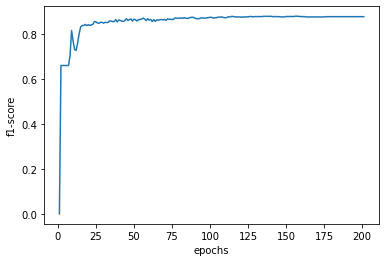

In [29]:
sns.lineplot(data={"f1-score": val_f1_score_history,
                   "epochs": list(range(1, EPOCHS + 2))}, x="epochs", y="f1-score")

## 9. Проверим точность нашей модели на тест части датасета

In [30]:
X_test = torch.Tensor(X_test)

Y_test = torch.Tensor(np.array(Y_test, dtype=np.float64)).type(torch.LongTensor)

best_model.eval()
y_head = best_model(X_test)
y_pred = torch.max(y_head, 1)[1]

for i in sample(list(range(500)), 10):
    print(test_title[i], "pred", y_pred[i].item(), "is_fake", int(Y_test[i].item()))

print("\nModel F1 SCORE is ", f1_score(y_pred, Y_test))
model_plot = ""  # input()
if model_plot != "":
    with open("used_models.txt", mode="a") as f:
        f.write(model_plot + ";" + str(EPOCHS) + ";" + str(f1_score(y_pred, Y_test)) + "\n")

власть керчь пожаловаться отсутствие автоподход крымский мост pred 1 is_fake 0
коммерческий спутник сфотографировать китайский туннель подлодка pred 0 is_fake 0
суд отклонить иск навальный оператор система платон pred 0 is_fake 0
эколог бить тревога строительство северный поток увеличить число случай депрессия пингвин pred 1 is_fake 1
начо дуато поставить михайловский спать красавица pred 0 is_fake 0
россия перевести десятилетний финансовый план pred 0 is_fake 0
барселона забить безответный гол матч кубок испания pred 0 is_fake 0
российский суд впервые признать простолюдин pred 0 is_fake 1
сергей безруков жениться сценаристка ёлка pred 0 is_fake 0
фетисов взять дело пылев личный контроль pred 0 is_fake 0

Model F1 SCORE is  0.8687350835322196



# 00. Также попробуем использовать ruBERT для бинарной классификации

### 1. Загружаем модель

In [35]:
MODEL_NAME = "sberbank-ai/ruRoberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

#### Пример работы токенайзера

In [37]:
df = data
example_text = "фетисов взять дело пылев личный контроль"
bert_input = tokenizer(example_text, padding='max_length', max_length = 32, 
                       truncation=True, return_tensors="pt")

print(bert_input['input_ids'])
# print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[    1, 16283, 13874,  3947,  1418,  9651,   375, 16287,  7274,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


### 2. Теперь определим класс датасета (torch.utils.data.Dataset)

In [38]:
import torch
import numpy as np


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [x for x in df.is_fake]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length=64, truncation=True,
                                return_tensors="pt") for text in df.title]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

### 3. Разделим датасет на обучающую, валидационную и тестовую подвыборки

In [39]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

### 4. Теперь давайте построим модель, используя предварительно обученную базовую модель ruBERT

In [40]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1024, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

#### Как видно из приведенного выше кода, модель BERT выводит две переменные:
* Первая переменная, которую я назвал *_* в приведенном выше коде, содержит векторы встраивания всех токенов в последовательность.
* Вторая переменная содержит вектор встраивания токена [ CLS ]. Для задачи классификации текста достаточно использовать это встраивание в качестве входных данных для нашего классификатора. *pooled_output*

=> Затем мы передаем переменную в линейный слой с функцией активации ReLU. В конце линейного слоя у нас есть вектор размера 2, каждый из которых соответствует категории наших лейблов (фейк, не фейк).

### 5. Переходим к самому скрипту обучения - циклы трейна и валидации

In [ ]:
from torch.optim import Adam

def train(model, train_data, val_data, learning_rate, epochs, batch_size=1):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    best_f1 = 0

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, mode='max', factor=0.75, patience=15)

    model.to(DEVICE)
    criterion.to(DEVICE)

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm.notebook.tqdm(train_dataloader):

                train_label = train_label.type(torch.LongTensor).to(device)
                mask = train_input['attention_mask'].type(torch.LongTensor).to(device)
                input_id = train_input['input_ids'].squeeze(1).type(torch.LongTensor).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.type(torch.LongTensor).to(device)
                    mask = val_input['attention_mask'].type(torch.LongTensor).to(device)
                    input_id = val_input['input_ids'].type(torch.LongTensor).squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            
            scheduler.step(total_acc_val / len(val_data))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

            if total_acc_val / len(val_data) >= best_f1 and total_acc_val / len(val_data) >= 0.80:
                best_f1 = total_acc_val / len(val_data)
                torch.save(model, "files/bert_classification.pth")
                print("MODEL_SAVED")

EPOCHS = 10
model = BertClassifier()
LR = 1e-6
batch_size = 30
              
train(model, df_train, df_val, LR, EPOCHS, batch_size=batch_size)

### 6. Проверим точность нашей модели на тест части датасета

In [46]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    model = model.to(DEVICE)

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in tqdm.notebook.tqdm(test_dataloader):

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

model = torch.load("files/bert_classification_final.pth")
evaluate(model, df_test)

  0%|          | 0/288 [00:00<?, ?it/s]

Test Accuracy:  0.885


## => 999. Создаём предсказания для test.tsv

In [ ]:
model = torch.load("files/bert_classification_final.pth", map_location=torch.device('cpu'))

test_data = pd.read_csv("dataset/test.tsv", sep="\t")
test_data = data.sample(frac=1)

test = Dataset(test_data)

test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

model.to(DEVICE)

with torch.no_grad():
    y_pred = []
    for test_input, test_label in tqdm.notebook.tqdm(test_dataloader):
        test_label = test_label.to(DEVICE)
        mask = test_input['attention_mask'].to(DEVICE)
        input_id = test_input['input_ids'].squeeze(1).to(DEVICE)

        output = model(input_id, mask)

        y_pred.append(output.argmax(dim=1))

test_data.is_fake = y_pred
test_data.to_csv("predictions.tsv", index=False)

test_data.head(10)

## 11. Итог
* за месяц я успел поиграться с CATBOOSTом - получилось добиться где-то F1-скор **~0.82**
* также перепробовал различные способы векторизации предложений(в добавок к тем, которые используются в ноутбуке
    использовал "мешок слов")
* **ruBERT**: Попробовал различные модельки от **DeepPavlov, sberbank-ai, cointegrated**,
    но сильных изменений в скоре это не дало, НООО всё же BERT показал скор лучше на ~0.05, чем линейная модель

=> Так что итоговые предсказания были сформированы ruBERTой